In [1]:
from utils import *
from prepare_ds import *
from train_ml import *
from create_map import *
from validation import *
from visualisation import *
from tqdm import tqdm

downgrade_labels = False
force = False

if downgrade_labels:
    src = DEFAULT_PATH["labels"]
    out = DEFAULT_PATH["labels"] + "downgraded/"
    classes_matching = DEFAULT_PATH["labels"] + "classes_matching.csv"
    downgrade_classes(src, out, classes_matching, force=True)
    DEFAULT_PATH["labels"] = out

# you can use force=True for re-write all caches.
signs = parse_tifs_from(DEFAULT_PATH["images"], "sign", force=force)
signs = signs.query("type == 'sign'")
labels = parse_tifs_from(DEFAULT_PATH["labels"], "label", force=force)
labels = labels.query("type == 'label'")

# Prepare data for generate_dataset.
year = 2020
only_bands = ["r", "b", "g", "n"]
signs_paths = signs.query(
    f"year == {year} and season == '90d' and band in @only_bands"
).sort_values("band")
signs_paths = signs_paths["path"].to_list()
labels_paths = labels.query(f"year == {year}")["path"].to_list()

Initialization paths...
All paths was initialized.
Load 'sign' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_sign.csv
Load 'label' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_label.csv


In [11]:
config_grid = {
    "resize": ["by_label"],
    "mask_mode": ["homogeneous"],
    # "mask_mode": ["homogeneous"],
    "r": [1],
    # "r": [1],
    # "percent": [0.05 * i for i in range(4)[1:]],
    "percent": [0.02],
    "homogen_percent": [0.02 * i for i in range(10)][1:],
    # "homogen_percent": [0.1],
    # "stratify": [False, True],
    "stratify": [False],
}

best_models = analyse_best_model(
    config_grid, signs_paths, labels_paths, store_models=True, verbose=False
)

Training set of models...:   0%|          | 0/9 [00:00<?, ?it/s]

/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/labels_230m/downgraded/landcover23c_v571_2020.Samara.tif
Finded gomogeneous layer. Load it.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Start resizing of homoheneous layer.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/layers/homogeneous_layer.tif
Files was loaded.
Mode: homogeneous & stratify False: (array([1, 2, 3, 4, 5, 6], dtype=uint8), array([154, 946, 496,  12,   9,  20]))


/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/labels_230m/downgraded/landcover23c_v571_2020.Samara.tif
Finded gomogeneous layer. Load it.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Start resizing of homoheneous layer.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/layers/homogeneous_layer.tif
Files was loaded.
Mode: homogeneous & stratify False: (array([1, 2, 3, 4, 5, 6], dtype=uint8), array([ 280, 1929,  989,   36,   14,   38]))


Training set of models...:  22%|██▏       | 2/9 [00:14<00:50,  7.28s/it]

/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/labels_230m/downgraded/landcover23c_v571_2020.Samara.tif
Finded gomogeneous layer. Load it.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Start resizing of homoheneous layer.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/layers/homogeneous_layer.tif
Files was loaded.
Mode: homogeneous & stratify False: (array([1, 2, 3, 4, 5, 6], dtype=uint8), array([ 414, 2897, 1487,   43,   16,   53]))


Training set of models...:  33%|███▎      | 3/9 [00:21<00:41,  6.94s/it]

/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/labels_230m/downgraded/landcover23c_v571_2020.Samara.tif
Finded gomogeneous layer. Load it.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Start resizing of homoheneous layer.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/layers/homogeneous_layer.tif
Files was loaded.
Mode: homogeneous & stratify False: (array([1, 2, 3, 4, 5, 6], dtype=uint8), array([ 617, 3747, 1968,   68,   27,   80]))


/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/labels_230m/downgraded/landcover23c_v571_2020.Samara.tif
Finded gomogeneous layer. Load it.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Start resizing of homoheneous layer.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/layers/homogeneous_layer.tif
Files was loaded.
Mode: homogeneous & stratify False: (array([1, 2, 3, 4, 5, 6], dtype=uint8), array([ 690, 4667, 2476,  117,   35,   95]))


/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/labels_230m/downgraded/landcover23c_v571_2020.Samara.tif
Finded gomogeneous layer. Load it.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Start resizing of homoheneous layer.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/layers/homogeneous_layer.tif
Files was loaded.
Mode: homogeneous & stratify False: (array([1, 2, 3, 4, 5, 6], dtype=uint8), array([ 936, 5611, 2776,  129,   36,  113]))


Training set of models...:  67%|██████▋   | 6/9 [00:40<00:19,  6.59s/it]

/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/labels_230m/downgraded/landcover23c_v571_2020.Samara.tif
Finded gomogeneous layer. Load it.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Start resizing of homoheneous layer.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/layers/homogeneous_layer.tif
Files was loaded.
Mode: homogeneous & stratify False: (array([1, 2, 3, 4, 5, 6], dtype=uint8), array([1138, 6437, 3168,  142,   51,  122]))


Training set of models...:  78%|███████▊  | 7/9 [00:47<00:13,  6.61s/it]

/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/labels_230m/downgraded/landcover23c_v571_2020.Samara.tif
Finded gomogeneous layer. Load it.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Start resizing of homoheneous layer.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/layers/homogeneous_layer.tif
Files was loaded.
Mode: homogeneous & stratify False: (array([1, 2, 3, 4, 5, 6], dtype=uint8), array([1281, 7160, 3663,  155,   58,  133]))


Training set of models...:  89%|████████▉ | 8/9 [00:54<00:06,  6.73s/it]

/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/labels_230m/downgraded/landcover23c_v571_2020.Samara.tif
Finded gomogeneous layer. Load it.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Start resizing of homoheneous layer.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/layers/homogeneous_layer.tif
Files was loaded.
Mode: homogeneous & stratify False: (array([1, 2, 3, 4, 5, 6], dtype=uint8), array([1558, 7751, 4026,  195,   70,  169]))


Training set of models...: 100%|██████████| 9/9 [01:01<00:00,  6.85s/it]


<Figure size 640x480 with 0 Axes>

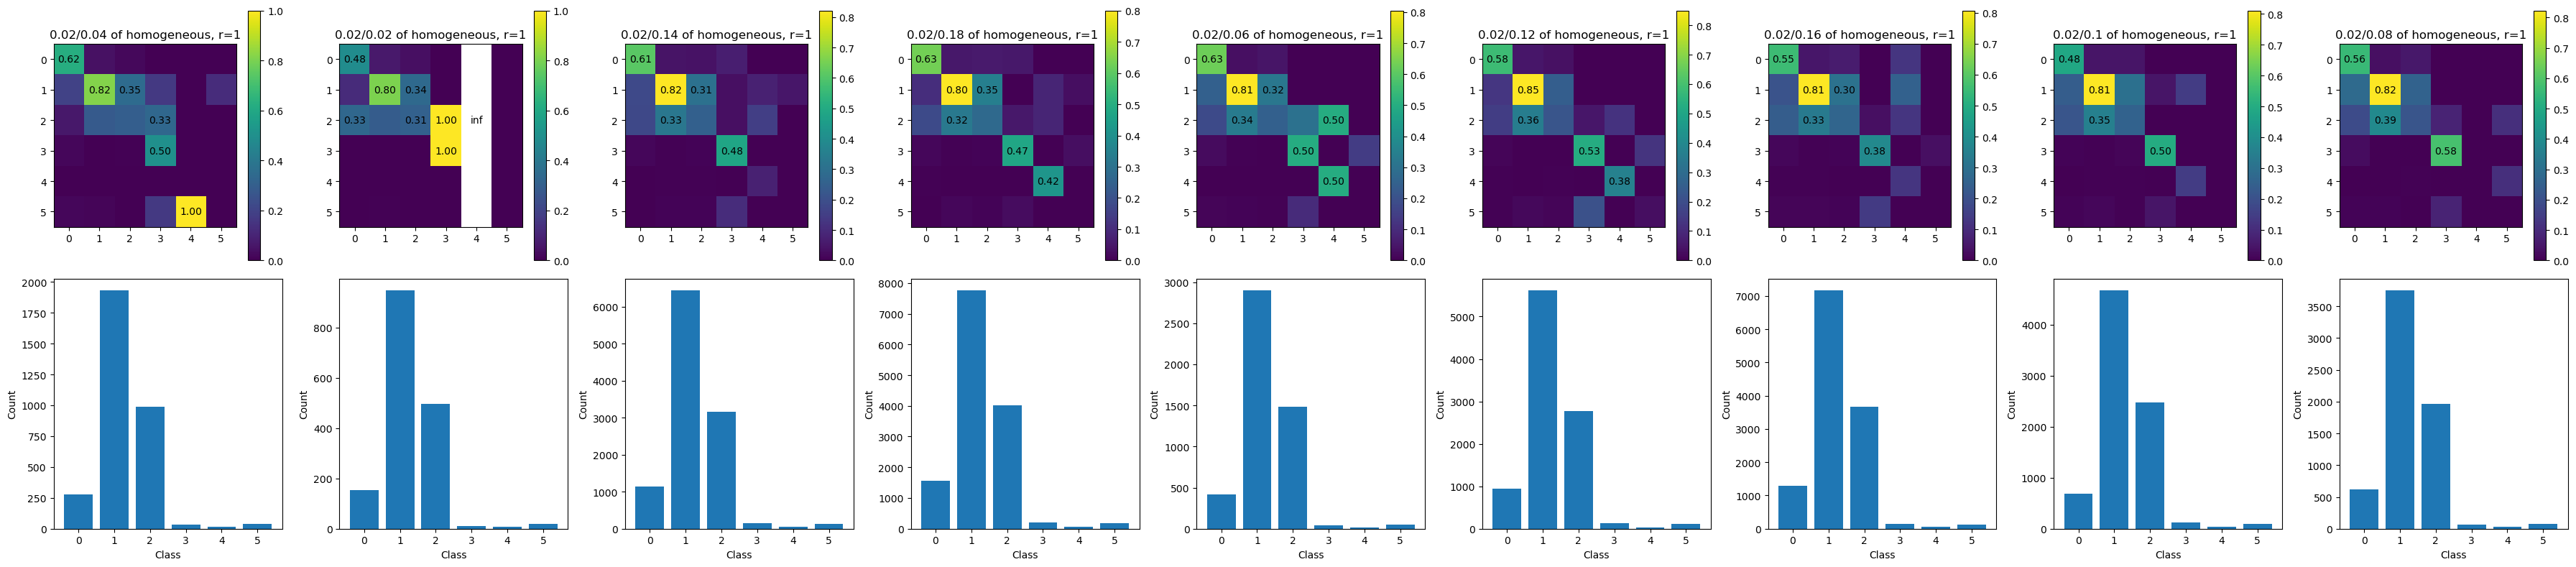

In [13]:
take_first = len(best_models)
models = []

for m in best_models[:take_first]:
    models.append(
        {
            "model": m["model"],
            "report": m["report"],
            "cf_matrix": m["cf_matrix"],
            "f1": m["f1_score"],
        }
    )

spyder_eye(best_models, models)

Load 'tile' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_tile.csv
Reshaping tensor-images...
Start create of map...

map size: x = 10980, y = 10980, bands = 4, total px=120560400


Creating map...: 100%|██████████| 58/58 [10:29<00:00, 10.86s/it]


Map is done.
Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/10.5min_/Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/auto_10m_0.626_homogeneous_0.02_0.0.tif
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/10.5min_/Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/auto_10m_0.626_homogeneous_0.02_0.0.tif
Files was loaded.
Etalons will be loaded from cache.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.


/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

TypeError: 'Axes' object is not subscriptable

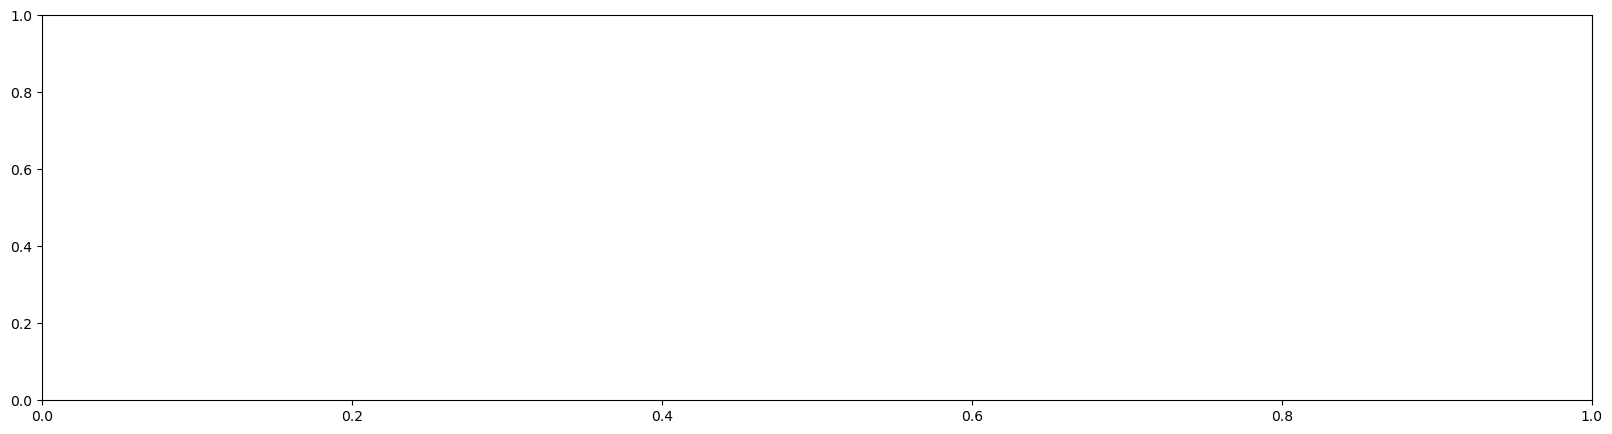

In [19]:
do_create_map = True
if do_create_map:
    # Получаем эталоны
    etalons = DEFAULT_PATH["etalons"]
    map_name = "wc"
    etalons_list = parse_tifs_from(etalons, typeof="etalon", verbose=False)
    etalons_list = etalons_list.query(f"year == {year} and map =='{map_name}'")[
        "path"
    ].to_list()

    # Загружаем тайлы с учетом quality
    quality = True
    if quality:
        tiles = DEFAULT_PATH["images"] + "tiles/"
        tiles = parse_tifs_from(tiles, typeof="tile", verbose=True)
        tiles = tiles.query("band in @only_bands").sort_values("band")["path"]
        tiles = tiles.to_list()
        loaded_tiles = []
        for t in tiles:
            loaded_tiles.append(load_tif(t, only_first=True, verbose=False))
    else:
        _, _, loaded_tiles, _ = generate_dataset(
            signs_paths, labels_paths, percent=0.0001, verbose=False
        )

    # Сортируем модели по f1_score
    sorted_models = sorted(
        zip(best_models, models), key=lambda x: x[0]["f1_score"], reverse=True
    )[:1]

    predicted_res = []
    validation_res = []
    for idx, (bm, model_dict) in enumerate(sorted_models):
        m = model_dict["model"]
        mm = bm["mask_mode"]
        f1 = bm["f1_score"]
        pc = bm["percent"]
        tt = bm["train_time"]
        out = DEFAULT_PATH["output"] + f"auto_10m_{f1:.3f}_{mm}_{pc}_{tt}.tif"
        pred_map = create_map(loaded_tiles, m, out)
        predicted_res.append(pred_map)
        val_result = validate_how_tif(pred_map, etalons_list)
        validation_res.append({"model_idx": idx, "validation": val_result})

    # Визуализация: столбцы по убыванию f1_score
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, len(predicted_res), figsize=(20, 5))
    for i, pred_map in enumerate(predicted_res):
        # Предполагается, что pred_map - numpy array
        axes[i].imshow(pred_map)
        axes[i].set_title(f"Model {i + 1}\nf1={sorted_models[i][0]['f1_score']:.3f}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()
